In [2]:
import torch
import torch.nn as nn
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from PIL import Image
from torchinfo import summary
from tqdm.auto import tqdm

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

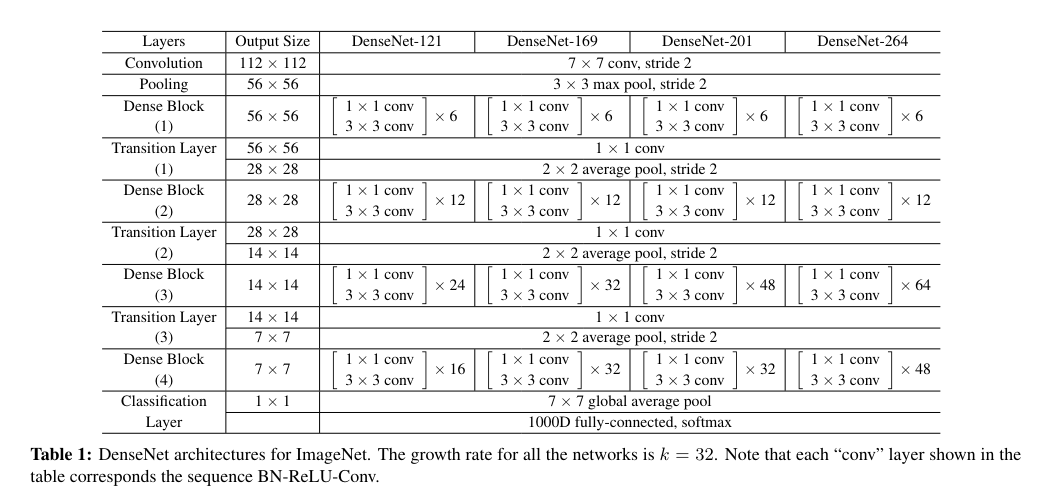

In [4]:
class BottleNeck(nn.Module):
    def __init__(self, in_channels, k:int):
        super(BottleNeck, self).__init__()

        self.residual = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, 4*k, kernel_size=1, bias=False),
            nn.BatchNorm2d(4*k),
            nn.ReLU(inplace=True),
            nn.Conv2d(4*k, k, kernel_size=3, padding=1, bias=False)
        )

    def forward(self, x):
        res_x = x.clone()
        x = self.residual(x)
        return torch.cat([x, res_x], 1)
    
class Transition(nn.Module):
    def __init__(self, in_channels):
        super(Transition, self).__init__()

        self.downsample = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, in_channels//2, kernel_size=1, bias=False),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )
    def forward(self, x):
        return self.downsample(x)

In [5]:
class DenseNet(nn.Module):
    def __init__(self, init_channels, growth_rate, layer_list, n_classes=1000):
        super(DenseNet, self).__init__()

        self.init_channels = init_channels
        self.k = growth_rate
        self.features = nn.Sequential(
            nn.Conv2d(3, init_channels, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(init_channels),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)            
        )
        self.dense_channels = init_channels
        dense_blocks = []
        dense_blocks.append(self.make_dense_block(layer_list[0]))
        dense_blocks.append(self.make_dense_block(layer_list[1]))
        dense_blocks.append(self.make_dense_block(layer_list[2]))
        dense_blocks.append(self.make_dense_block(layer_list[3], last_block=True))
        self.dense_blocks = nn.Sequential(*dense_blocks)
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(self.dense_channels, n_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.dense_blocks(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

    def make_dense_block(self, num_blocks, last_block=False):
        layers = []
        for _ in range(num_blocks):
            layers.append(BottleNeck(self.dense_channels, self.k))
            self.dense_channels += self.k

        if last_block:
            layers.append(nn.BatchNorm2d(self.dense_channels))
            layers.append(nn.ReLU(inplace=True))
        else:
            layers.append(Transition(self.dense_channels))
            self.dense_channels //= 2
        return nn.Sequential(*layers)





In [18]:
def DenseNet121(n_classes=1000):
    return DenseNet(init_channels=64, growth_rate=32, layer_list=[6, 12, 24, 16], n_classes=n_classes)
def DenseNet169(n_classes=1000):
    return DenseNet(init_channels=64, growth_rate=32, layer_list=[6, 12, 32, 32], n_classes=n_classes)
def DenseNet201(n_classes=1000):
    return DenseNet(init_channels=64, growth_rate=32, layer_list=[6, 12, 48, 32], n_classes=n_classes)
def DenseNet264(n_classes=1000):
    return DenseNet(init_channels=64, growth_rate=32, layer_list=[6, 12, 64, 48], n_classes=n_classes)

In [19]:
model = DenseNet121().to(device)
summary(model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                        Output Shape              Param #
DenseNet                                      [1, 1000]                 --
├─Sequential: 1-1                             [1, 64, 56, 56]           --
│    └─Conv2d: 2-1                            [1, 64, 112, 112]         9,408
│    └─BatchNorm2d: 2-2                       [1, 64, 112, 112]         128
│    └─ReLU: 2-3                              [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-4                         [1, 64, 56, 56]           --
├─Sequential: 1-2                             [1, 1024, 7, 7]           --
│    └─Sequential: 2-5                        [1, 128, 28, 28]          --
│    │    └─BottleNeck: 3-1                   [1, 96, 56, 56]           45,440
│    │    └─BottleNeck: 3-2                   [1, 128, 56, 56]          49,600
│    │    └─BottleNeck: 3-3                   [1, 160, 56, 56]          53,760
│    │    └─BottleNeck: 3-4                   [1, 192, 56, 56]          57,920


In [8]:
from torchvision.models import densenet121

model = densenet121()
summary(model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
DenseNet                                 [1, 1000]                 --
├─Sequential: 1-1                        [1, 1024, 7, 7]           --
│    └─Conv2d: 2-1                       [1, 64, 112, 112]         9,408
│    └─BatchNorm2d: 2-2                  [1, 64, 112, 112]         128
│    └─ReLU: 2-3                         [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-4                    [1, 64, 56, 56]           --
│    └─_DenseBlock: 2-5                  [1, 256, 56, 56]          --
│    │    └─_DenseLayer: 3-1             [1, 32, 56, 56]           45,440
│    │    └─_DenseLayer: 3-2             [1, 32, 56, 56]           49,600
│    │    └─_DenseLayer: 3-3             [1, 32, 56, 56]           53,760
│    │    └─_DenseLayer: 3-4             [1, 32, 56, 56]           57,920
│    │    └─_DenseLayer: 3-5             [1, 32, 56, 56]           62,080
│    │    └─_DenseLayer: 3-6             [1, 32, 56, 56]     

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import time
import copy

class NPYDataset(Dataset):
    def __init__(self, npy_dir, transform=None):
        self.npy_dir = npy_dir
        self.transform = transform
        self.data = []
        self.labels = []
        self.classes = sorted(os.listdir(npy_dir))

        for label, class_dir in enumerate(self.classes):
            class_path = os.path.join(npy_dir, class_dir)
            for file in os.listdir(class_path):
                if file.endswith('.npy'):
                    self.data.append(os.path.join(class_path, file))
                    self.labels.append(label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        npy_path = self.data[idx]
        image = np.load(npy_path)
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

def to_tensor(image):
    return torch.tensor(image, dtype=torch.float)

train_dataset = NPYDataset('E:\\puzzle\\data\\ImageNet10\\preprocessed\\train', transform=None)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = NPYDataset('E:\\puzzle\\data\\ImageNet10\\preprocessed\\val', transform=None)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
model = DenseNet121(n_classes=10).to(device)
loss_func = nn.CrossEntropyLoss(reduction='sum')
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def metric_batch(output, target):
    pred = output.argmax(dim=1, keepdim=True)
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects

def loss_batch(loss_func, outputs, target, opt=None):
    if isinstance(outputs, tuple):
        output, aux1, aux2 = outputs

        output_loss = loss_func(output, target)
        aux1_loss = loss_func(aux1, target)
        aux2_loss = loss_func(aux2, target)

        loss = output_loss + 0.3*(aux1_loss + aux2_loss)
        metric_b = metric_batch(output, target)
    else:
        loss = loss_func(outputs, target)
        metric_b = metric_batch(outputs, target)

    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()
    
    return loss.item(), metric_b

def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss = 0.0
    running_metric = 0.0
    len_data = len(dataset_dl.dataset)

    for xb, yb in tqdm(dataset_dl, leave=False):
        xb = xb.to(device)
        yb = yb.to(device)
        output = model(xb)

        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)

        running_loss += loss_b

        if metric_b is not None:
            running_metric += metric_b
        
        if sanity_check is True:
            break

    loss = running_loss / len_data
    metric = running_metric / len_data

    return loss, metric

def train_val(model, params):
    num_epochs = params["num_epochs"]
    loss_func = params["loss_func"]
    opt = params["optimizer"]
    train_dl = params["train_dl"]
    val_dl = params["val_dl"]
    sanity_check = params["sanity_check"]
    lr_scheduler = params["lr_scheduler"]
    path2weights = params["path2weights"]

    loss_history = {'train': [], 'val': []}
    metric_history = {'train': [], 'val': []}

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    
    start_time = time.time()
    for epoch in range(num_epochs):
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs - 1, current_lr))
        
        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, sanity_check, opt)
        loss_history['train'].append(train_loss)
        metric_history['train'].append(train_metric)

        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl, sanity_check)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

            torch.save(model.state_dict(), path2weights)
            print('Copied best model weights!')

        loss_history['val'].append(val_loss)
        metric_history['val'].append(val_metric)

        lr_scheduler.step()

        print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' % (train_loss, val_loss, 100 * val_metric, (time.time() - start_time) / 60))
        print('-' * 10)

    model.load_state_dict(best_model_wts)

    return model, loss_history, metric_history

params_train = {
    "num_epochs": 10,
    "loss_func": loss_func,
    "optimizer": optimizer,
    "train_dl": train_loader,
    "val_dl": val_loader,
    "sanity_check": False,
    "lr_scheduler": lr_scheduler,
    "path2weights": "best_weights.pt",
}

# 학습 및 유효성 검사 수행
model, loss_history, metric_history = train_val(model, params_train)

Epoch 0/9, current lr=0.01


  0%|          | 0/325 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

Copied best model weights!
train loss: 2.411695, val loss: 1.954150, accuracy: 27.35, time: 1.6767 min
----------
Epoch 1/9, current lr=0.01


  0%|          | 0/325 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

Copied best model weights!
train loss: 1.942352, val loss: 1.739301, accuracy: 33.38, time: 3.3686 min
----------
Epoch 2/9, current lr=0.01


  0%|          | 0/325 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

Copied best model weights!
train loss: 1.793268, val loss: 1.558815, accuracy: 41.73, time: 5.0205 min
----------
Epoch 3/9, current lr=0.01


  0%|          | 0/325 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

Copied best model weights!
train loss: 1.694251, val loss: 1.521065, accuracy: 45.85, time: 6.6218 min
----------
Epoch 4/9, current lr=0.01


  0%|          | 0/325 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

Copied best model weights!
train loss: 1.585956, val loss: 1.345898, accuracy: 51.58, time: 8.1917 min
----------
Epoch 5/9, current lr=0.01


  0%|          | 0/325 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

Copied best model weights!
train loss: 1.492475, val loss: 1.283839, accuracy: 55.54, time: 9.7578 min
----------
Epoch 6/9, current lr=0.01


  0%|          | 0/325 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

Copied best model weights!
train loss: 1.438162, val loss: 1.218955, accuracy: 56.92, time: 11.3270 min
----------
Epoch 7/9, current lr=0.01


  0%|          | 0/325 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

Copied best model weights!
train loss: 1.388561, val loss: 1.176984, accuracy: 58.50, time: 12.9995 min
----------
Epoch 8/9, current lr=0.01


  0%|          | 0/325 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

train loss: 1.335983, val loss: 1.185960, accuracy: 58.77, time: 14.6295 min
----------
Epoch 9/9, current lr=0.01


  0%|          | 0/325 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

Copied best model weights!
train loss: 1.271891, val loss: 1.164860, accuracy: 59.54, time: 16.2904 min
----------


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


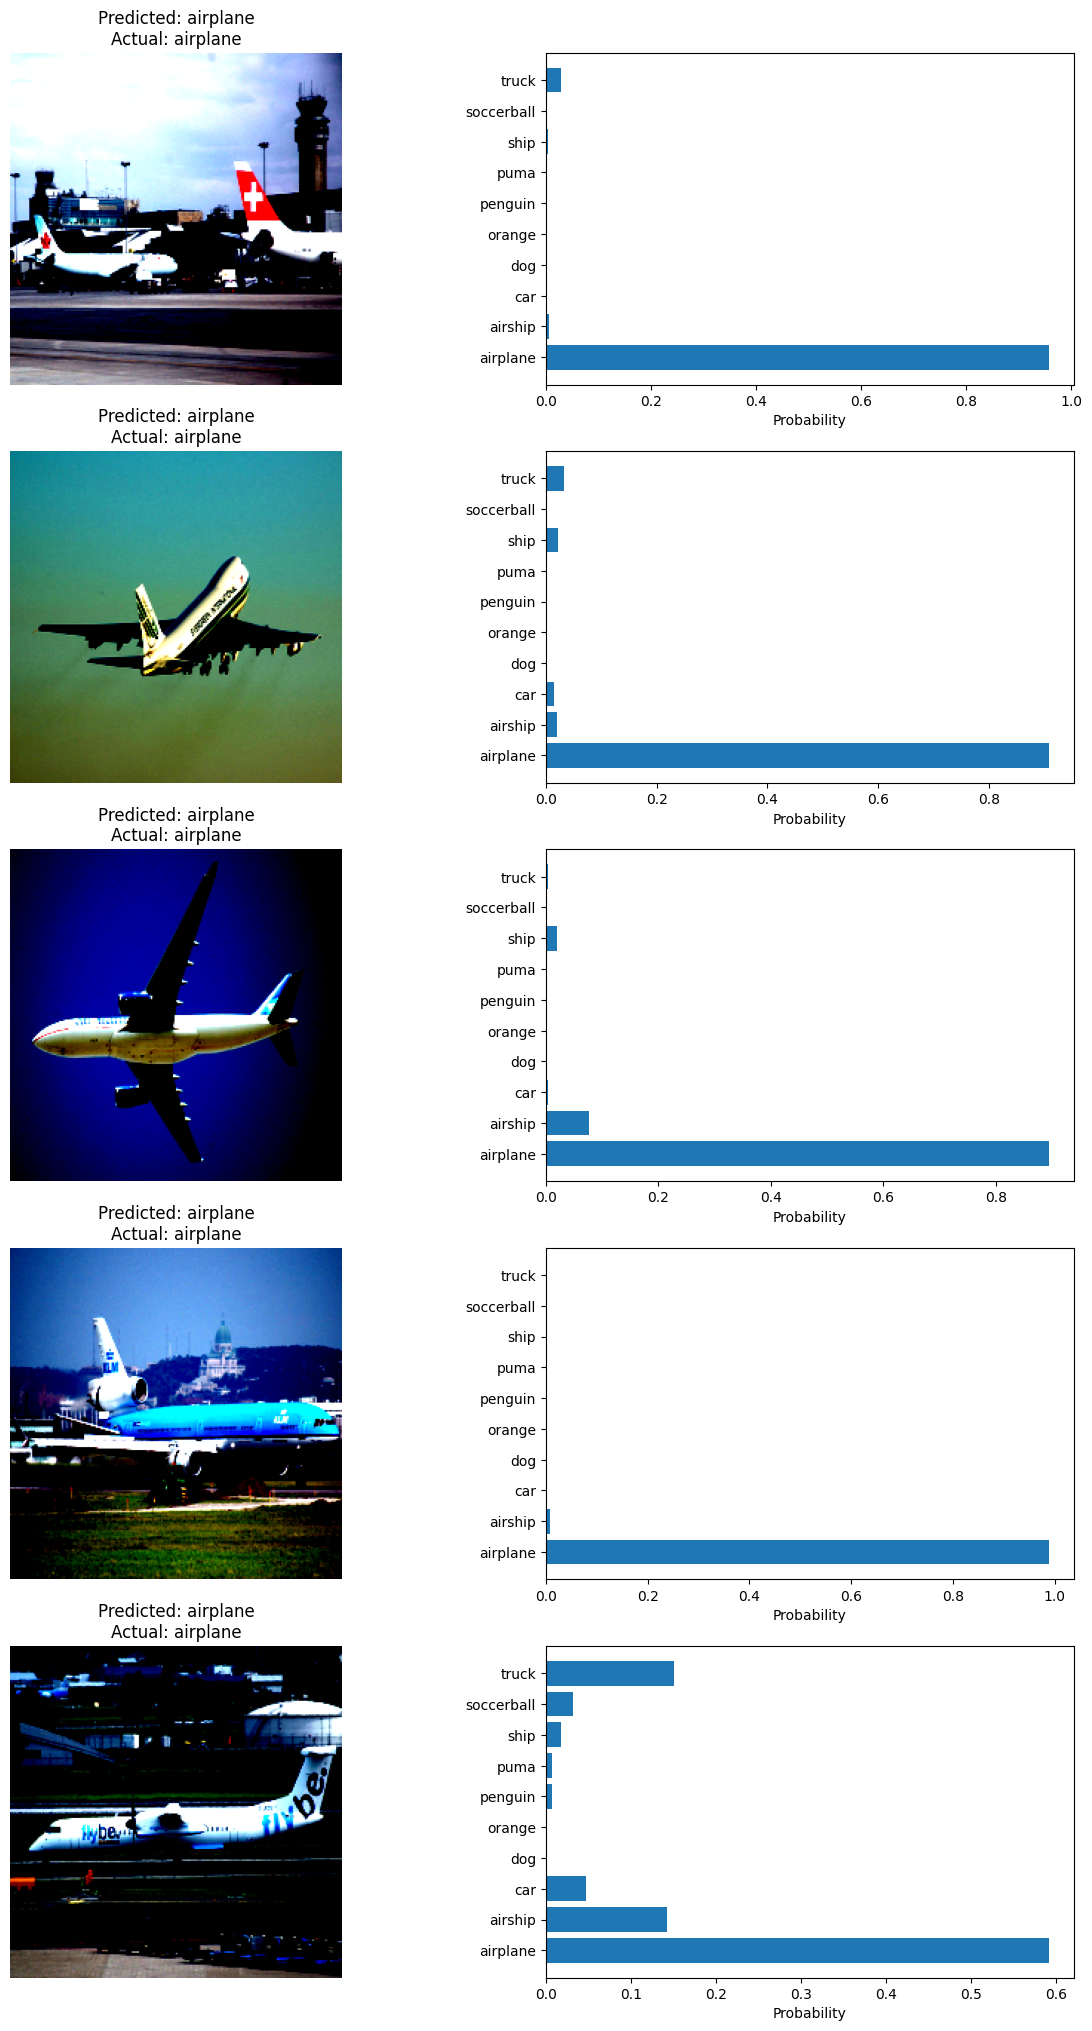

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
from PIL import Image

# Define a function to visualize the predictions
def visualize_predictions(model, loader, device, class_names, num_images=5):
    model.eval()
    images_so_far = 0

    plt.figure(figsize=(15, num_images * 5))

    with torch.no_grad():
        for i, (images, labels) in enumerate(loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for j in range(images.size(0)):
                images_so_far += 1
                if images_so_far > num_images:
                    return
                
                plt.subplot(num_images, 2, 2 * images_so_far - 1)
                plt.imshow(images.cpu().data[j].permute(1, 2, 0).numpy())
                plt.title(f'Predicted: {class_names[preds[j]]}\nActual: {class_names[labels[j]]}')
                plt.axis('off')

                plt.subplot(num_images, 2, 2 * images_so_far)
                probabilities = torch.nn.functional.softmax(outputs[j], dim=0)
                plt.barh(range(len(class_names)), probabilities.cpu().numpy())
                plt.yticks(range(len(class_names)), class_names)
                plt.xlabel('Probability')

# Assuming class_names is a list of class names corresponding to the dataset
class_names = train_dataset.classes

# Visualize predictions on validation set
visualize_predictions(model, val_loader, device, class_names, num_images=5)